In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
heart = pd.read_csv("heart_disease_uci.csv")
heart.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [4]:
heart.shape

(920, 16)

In [5]:
heart.isnull().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

In [6]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [7]:
#identify categorical and numerical columns
categorical_cols = heart.select_dtypes(include=['object', 'category']).columns
categorical_cols

Index(['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal'], dtype='object')

In [8]:
numerical_cols = heart.select_dtypes(include=['number']).columns
numerical_cols

Index(['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca', 'num'], dtype='object')

In [9]:
#fill missing values in numerical columns with the mean
heart[numerical_cols] =heart[numerical_cols].fillna(heart[numerical_cols].mean())

#fill missing values in categorical columns with the mode
for col in categorical_cols:
    heart[col] = heart[col].fillna(heart[col].mode()[0])

print(heart.isnull().sum())

id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


/var/folders/1s/zwpt56tn45l8gvrf6rftcbxm0000gn/T/ipykernel_8842/297130246.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heart[col] = heart[col].fillna(heart[col].mode()[0])


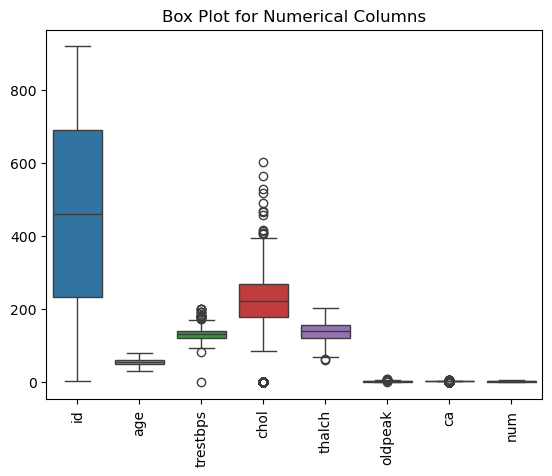

In [10]:
#check outliers
sns.boxplot(data=heart[numerical_cols])
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Box Plot for Numerical Columns')
plt.show()

In [11]:
#we will remove the outlier in chol and trestbps 
def remove_outliers(df, columns):
    for column in columns: 
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

heart = remove_outliers(heart, ['chol', 'trestbps'])

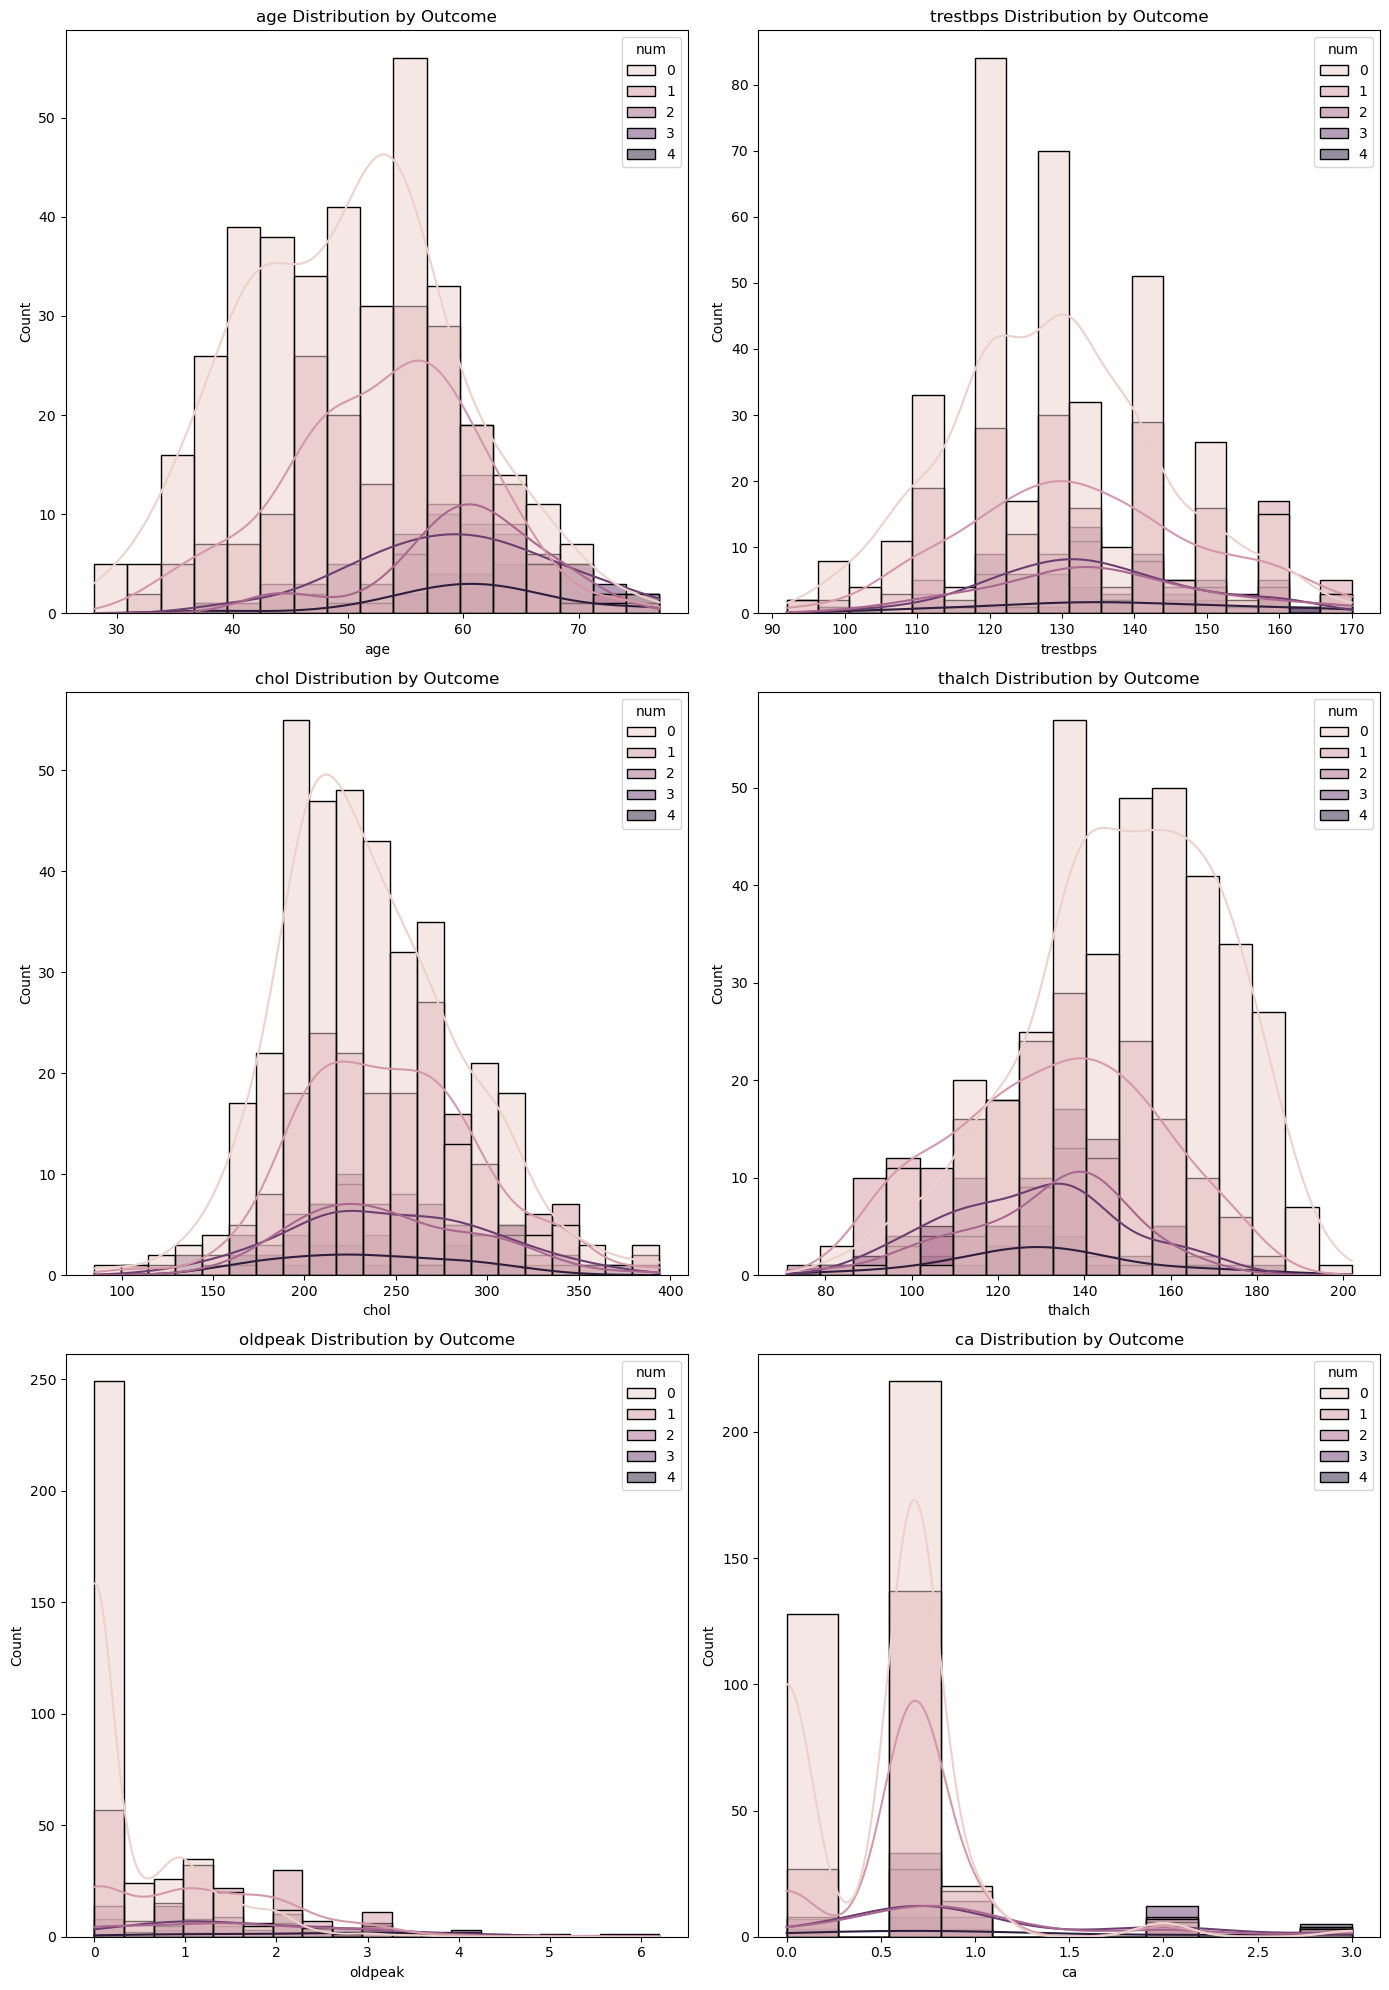

In [12]:
#data visualization
variables = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
fig, axes = plt.subplots(3, 2, figsize=(14, 20))  
axes = axes.flatten()  

for i, var in enumerate(variables):
    sns.histplot(data=heart, x=var, hue='num', kde=True, ax=axes[i])
    axes[i].set_title(f'{var} Distribution by Outcome')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

<Axes: >

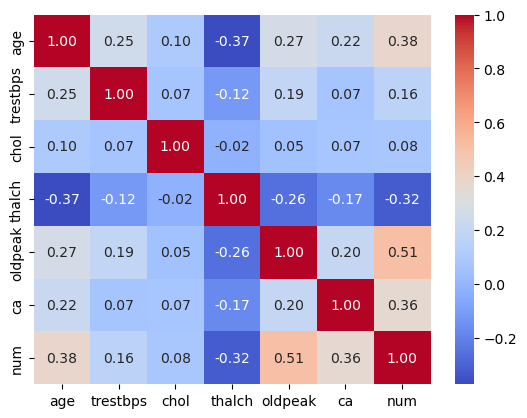

In [13]:
sns.heatmap(heart[variables + ["num"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")

In [14]:
#data processing
label_encoder = LabelEncoder()
binary_vars = ["sex","fbs", "exang"]
for var in binary_vars:
    heart[var] = label_encoder.fit_transform(heart[var])

#one-Hot Encoding
heart = pd.get_dummies(heart, columns=["cp", "dataset","restecg","slope", "thal"], drop_first=True)
heart= heart.astype(int)
heart.head()


,id,age,sex,trestbps,chol,fbs,thalch,exang,oldpeak,ca,...,cp_non-anginal,cp_typical angina,dataset_Hungary,dataset_VA Long Beach,restecg_normal,restecg_st-t abnormality,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
0,1,63,1,145,233,1,150,0,2,0,...,0,1,0,0,0,0,0,0,0,0
1,2,67,1,160,286,0,108,1,1,3,...,0,0,0,0,0,0,1,0,1,0
2,3,67,1,120,229,0,129,1,2,2,...,0,0,0,0,0,0,1,0,0,1
3,4,37,1,130,250,0,187,0,3,0,...,1,0,0,0,1,0,0,0,1,0
4,5,41,0,130,204,0,172,0,1,0,...,0,0,0,0,0,0,0,1,1,0


In [16]:
#create a new outcome col with 2 categories
heart['target'] = (heart['num'] > 0).astype(int)

X = heart.drop(columns=["id", "target"])
y = heart["target"]  

#standardization
scaler = StandardScaler()
heart_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)  

#split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(heart_scaled, y, test_size=0.3, random_state=123)

heart_scaled.head()

,age,sex,trestbps,chol,fbs,thalch,exang,oldpeak,ca,num,...,cp_non-anginal,cp_typical angina,dataset_Hungary,dataset_VA Long Beach,restecg_normal,restecg_st-t abnormality,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
0,1.068560,0.558504,0.895145,-0.143497,2.308123,0.372954,-0.721995,1.329255,-0.395054,-0.751407,...,-0.545565,4.107919,-0.795248,-0.508727,-1.217637,-0.451335,-1.610269,-0.536925,-1.818579,-0.475831
1,1.488006,0.558504,1.874881,0.938872,-0.433252,-1.380030,1.385051,0.324585,4.064897,1.075995,...,-0.545565,-0.243432,-0.795248,-0.508727,-1.217637,-0.451335,0.621014,-0.536925,0.549880,-0.475831
2,1.488006,0.558504,-0.737748,-0.225185,-0.433252,-0.503538,1.385051,1.329255,2.578247,0.162294,...,-0.545565,-0.243432,-0.795248,-0.508727,-1.217637,-0.451335,0.621014,-0.536925,-1.818579,2.101587
3,-1.657837,0.558504,-0.084591,0.203678,-0.433252,1.917250,-0.721995,2.333924,-0.395054,-0.751407,...,1.832964,-0.243432,-0.795248,-0.508727,0.821263,-0.451335,-1.610269,-0.536925,0.549880,-0.475831
4,-1.238391,-1.790498,-0.084591,-0.735737,-0.433252,1.291184,-0.721995,0.324585,-0.395054,-0.751407,...,-0.545565,-0.243432,-0.795248,-0.508727,-1.217637,-0.451335,-1.610269,1.862458,0.549880,-0.475831


In [26]:
#try the feature selection technique
from sklearn.linear_model import LassoCV

#use LASSO to do the feature selection
lasso = LassoCV(cv=5, random_state=123)  
lasso.fit(X_train, y_train)

selected_features = X_train.columns[lasso.coef_ != 0]
print("Selected Features:", selected_features)

Selected Features: Index(['sex', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak', 'num',
       'cp_atypical angina', 'cp_non-anginal', 'dataset_Hungary',
       'restecg_normal', 'slope_flat', 'thal_normal'],
      dtype='object')


In [27]:
X_train = X_train[selected_features]
X_test= X_test[selected_features]

X_train.head()

,sex,chol,fbs,thalch,exang,oldpeak,num,cp_atypical angina,cp_non-anginal,dataset_Hungary,restecg_normal,slope_flat,thal_normal
196,0.558504,-0.817425,-0.433252,-0.628751,1.385051,-0.680084,1.989696,-0.539086,-0.545565,-0.795248,-1.217637,0.621014,-1.818579
45,0.558504,-1.327976,-0.433252,-0.753964,-0.721995,-0.680084,-0.751407,-0.539086,1.832964,-0.795248,0.821263,-1.610269,0.549880
320,-1.790498,-1.185022,-0.433252,1.625086,-0.721995,-0.680084,-0.751407,-0.539086,1.832964,1.257469,-1.217637,0.621014,0.549880
479,0.558504,-2.512455,-0.433252,-0.294849,1.385051,1.329255,0.162294,-0.539086,-0.545565,1.257469,0.821263,0.621014,0.549880
156,-1.790498,-0.531516,-0.433252,0.706856,-0.721995,0.324585,-0.751407,-0.539086,1.832964,-0.795248,0.821263,0.621014,0.549880


In [28]:
##logistic regression
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train, y_train)
y_pred_log = logistic_regression.predict(X_test)
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00       105

    accuracy                           1.00       215
   macro avg       1.00      1.00      1.00       215
weighted avg       1.00      1.00      1.00       215



In [18]:
#define the function for confusion matrix
def plot_confusion_matrix(y_test, y_prediction):
    cm = metrics.confusion_matrix(y_test, y_prediction)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
    ax.set_xlabel('Prediced labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['No Diabetes', 'Diabetes'])
    ax.yaxis.set_ticklabels(['No Diabetes', 'Diabetes']) 
    plt.show()

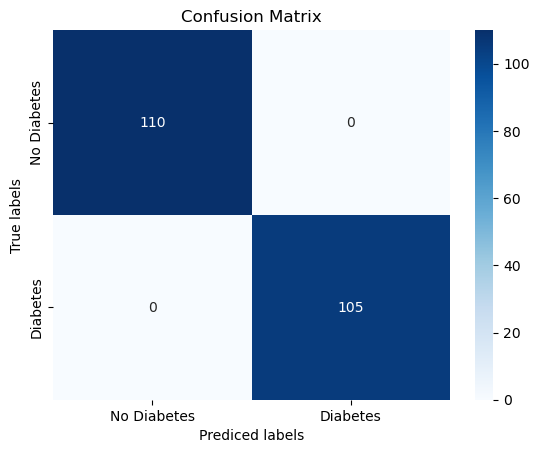

In [29]:
plot_confusion_matrix(y_test, y_pred_log)

In [30]:
#calculate the sensitivity and specificity
cm_log = confusion_matrix(y_test, y_pred_log)
TN, FP, FN, TP = cm_log.ravel()
sensitivity = TP / (TP + FN)  
specificity = TN / (TN + FP)  
print(f"Sensitivity: {sensitivity:.2f}") 
print(f"Specificity: {specificity:.2f}") 

Sensitivity: 1.00
Specificity: 1.00


Best k based on Elbow Method: 5


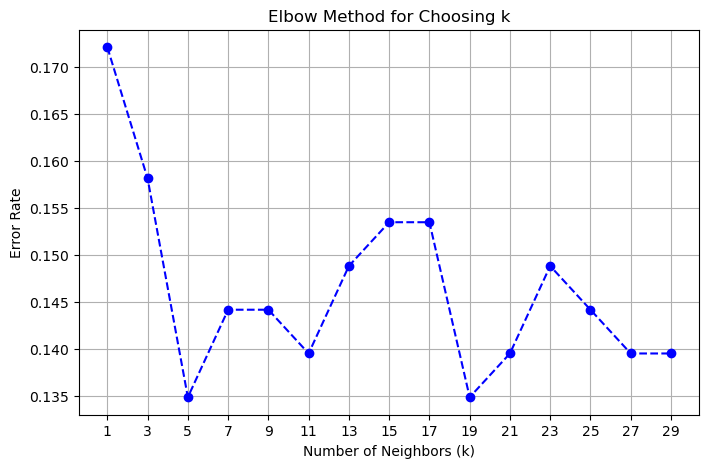

In [31]:
##KNN
#use the elbow method to find the best k
k_values = range(1, 30, 2)  
error_rates = []  

# compute error rate for different k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)  
    y_pred = knn.predict(X_test)  
    error = 1 - accuracy_score(y_test, y_pred)  
    error_rates.append(error)

# plot k vs. error rate 
plt.figure(figsize=(8, 5))
plt.plot(k_values, error_rates, marker='o', linestyle='dashed', color='b')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Error Rate")
plt.title("Elbow Method for Choosing k")
plt.xticks(k_values)  
plt.grid(True)

best_k = k_values[np.argmin(error_rates)]
print(f"Best k based on Elbow Method: {best_k}")

plt.show()

              precision    recall  f1-score   support

           0       0.86      0.87      0.87       110
           1       0.87      0.86      0.86       105

    accuracy                           0.87       215
   macro avg       0.87      0.86      0.87       215
weighted avg       0.87      0.87      0.87       215



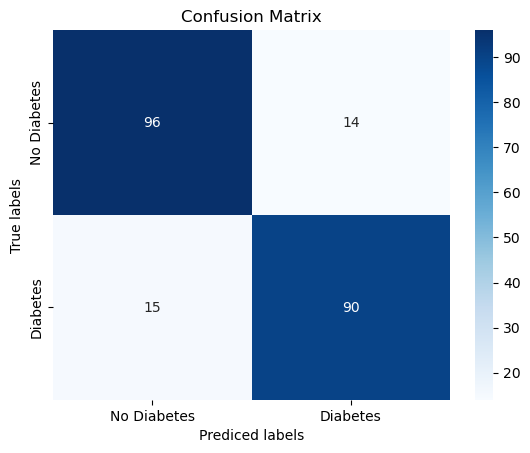

Sensitivity: 0.86
Specificity: 0.87


In [32]:
# use the optimal k for the model
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)  # Train the model on the full training set
y_pred_knn = knn.predict(X_test)

print(classification_report(y_test, y_pred_knn))

#display the confusion matrix
plot_confusion_matrix(y_test, y_pred_knn)

cm_knn = confusion_matrix(y_test, y_pred_knn)
TN, FP, FN, TP = cm_knn.ravel()
sensitivity = TP / (TP + FN)   
specificity = TN / (TN + FP)  
print(f"Sensitivity: {sensitivity:.2f}") 
print(f"Specificity: {specificity:.2f}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       110
           1       1.00      1.00      1.00       105

    accuracy                           1.00       215
   macro avg       1.00      1.00      1.00       215
weighted avg       1.00      1.00      1.00       215



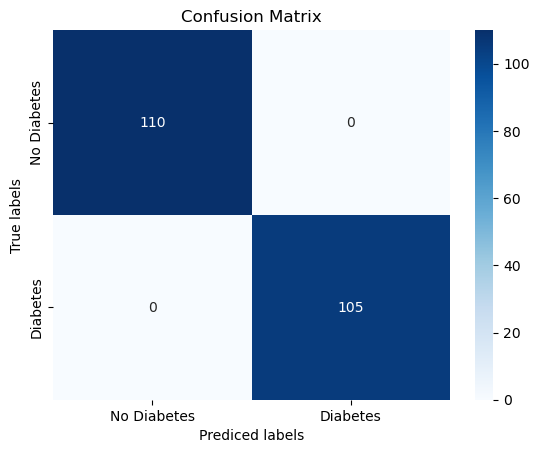

Sensitivity: 1.00
Specificity: 1.00


In [33]:
##neural network
#basic model
mlp_baseline = MLPClassifier(hidden_layer_sizes=(32,),  
                             activation='relu',       
                             solver='adam',           
                             max_iter=1000,           
                             random_state=123)

mlp_baseline.fit(X_train, y_train)
y_pred_nn_baseline = mlp_baseline.predict(X_test)

print(classification_report(y_test, y_pred_nn_baseline))
plot_confusion_matrix(y_test, y_pred_nn_baseline)

cm_nn_baseline = confusion_matrix(y_test, y_pred_nn_baseline)
TN, FP, FN, TP = cm_nn_baseline.ravel()
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")